In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)

import matplotlib.pyplot as plt


class ExampleMDP(object):
    
    """
    MDP Overview:
    
        N(-0.1, 1)
    T      <---                 start              T
    0      <---    1     <---     2     --->      3
           <---           a=0           a=1
    """
    
    def __init__(self):
        
        self.P = {0 : {0 : (1.0, 0, 0.0, True),
                       1 : (1.0, 0, 0.0, True)
                      },
                  1 : {0 : (1.0, 0, 0.0, True),
                       1 : (1.0, 0, 0.0, True)
                      },
                  2 : {0 : (1.0, 1, 0.0, False),
                       1 : (1.0, 3, 0.0, True)
                      },
                  3 : {0 : (1.0, 3, 0.0, True),
                       1 : (1.0, 3, 0.0, True)
                      }
                 }
        
        self.nA = 2
        self.nS = 4
        # return current state
        self.cS = None
        
    def reset(self):
        self.cS = 2 # Always start in 2
        return self.cS
    
    def step(self, action):
        
        probability, next_state, reward, done = self.P[self.cS][action]
        
        # produce new reward if in state 1:
        if self.cS == 1:
            reward = np.random.normal(-0.1, 1)    
        
        self.cS = next_state
        
        return next_state, reward, done, {'prob' : probability}

In [5]:
env = ExampleMDP()
state = env.reset()
print('Home:\t\t', state)
# go left = 0
# go right = 1
state = env.step(1)
print('To right:\t', state)

state = env.reset()
print('Reset:\t\t', state)
state = env.step(0)
print('To left:\t', state)
state = env.step(0)
print('To left:\t', state)

Home:		 2
To right:	 (3, 0.0, True, {'prob': 1.0})
Reset:		 2
To left:	 (1, 0.0, False, {'prob': 1.0})
To left:	 (0, -0.6174184959606214, True, {'prob': 1.0})


100%|██████████| 10000/10000 [10:35<00:00, 15.73it/s]


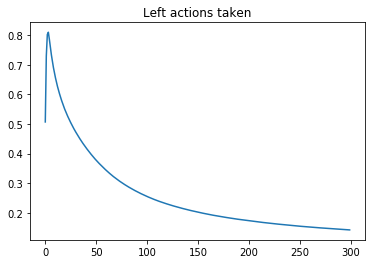

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = (np.zeros(env.nA) + epsilon) / env.nA
        
        if np.count_nonzero(Q) == 0:
            best = np.random.choice(range(env.nA))
        else:
            best = np.argmax(Q[observation])
        
        A[best] += (1.0 - epsilon)
        return A
        
    return policy_fn

def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.nA))
    
    # Keeps track of useful statistics
    stats = []
    action_left = 0

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.nA)
    
    for i_episode in range(num_episodes):
        #i = 0
        R = 0

        current_state = env.reset()
        current_A = policy(current_state)

        current_action = np.random.choice(range(env.nA), p=current_A)
        
        if current_action == 0:
            action_left += 1

        while True:
            
            next_state, reward, done, _ = env.step(current_action)
            next_A = policy(next_state)

            next_action = np.random.choice(range(env.nA), p=next_A)
            
            target = reward + (discount_factor * max(Q[next_state]) - Q[current_state][current_action])
            Q[current_state][current_action] += alpha * target
            
            #i += 1
            R += reward
            
            if done:
                break
            
            current_state, current_action = next_state, next_action

        stats.append((action_left / (i_episode+1), i_episode))
    return Q, zip(*stats)

RUNS = 10000
EPISODES = 300

data = np.zeros((RUNS, EPISODES))
for i in tqdm(range(RUNS)):
    _, (left_ratio, episode_nr) = q_learning(env, EPISODES)
    data[i, :] = left_ratio

# Plot percentage actions left over episodes:
plt.plot(data.mean(0))
plt.title('Left actions taken')
plt.show()